# Example of use of the mpc_solver module 

This is a notebook serving to illustrate the use of the module mpc_solver that enables to derive deterministic MPC feedback for general nonlinear systems governed by a system of ODEs. It also provides many useful utilities including those simulating the closed-loop system under the MPC feedback. The later can be computed either using IPOPT solver via Casadi or using a fast gradient algorithm. 

In [17]:
from mpc_solver import MPC
from casadi import vertcat
import numpy as np
import time 
import matplotlib.pyplot as plt

latex = False

if latex:
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "font.size":18
    })


## Define the user-specific funcitons

### ode

In [18]:
def ode_pvtol(x, u, w, p):

    eps, gain = w[0], w[1]
    xdot = vertcat(
        x[3], x[4], x[5], 
        -u[0] * np.sin(x[2]) + eps * gain * u[1] * np.cos(x[2]), 
        u[0] * np.cos(x[2]) + eps * gain * u[1] * np.sin(x[2])-1, 
        gain * u[1]
    )
    return xdot 


### stage cost 

In [19]:
def stage_cost_pvtol(x, u, w, p):

    # par = vertcat(yd, zd, qy, qz, qtheta, rho_f)
    yd, zd = p[0], p[1]
    q = vertcat(p[2], p[3], p[4], 1, 1, 1)
    xd = vertcat(yd, zd, 0, 0, 0, 0)
    ud = np.array([1, 0])
    ex = x - xd
    eu = u - ud
    ell = 0 
    for i in range(6):
        ell += q[i] * ex[i] ** 2
    for i in range(2):
        ell += eu[i] ** 2
    return ell

### terminal cost 

In [20]:
def terminal_cost_pvtol(x, w, p):
    
    # par = vertcat(yd, zd, qy, qz, qtheta, rho_f)
    
    yd, zd = p[0], p[1]
    rho_f = p[5]
    q = vertcat(p[2], p[3], p[4], 1, 1, 1)
    xd = vertcat(yd, zd, 0, 0, 0, 0)
    psi = 0
    ex = x-xd
    for i in range(6):
        psi += rho_f * q[i] * ex[i] ** 2
    return psi


### constraints

In [21]:
def constraints_pvtol(x, u, w, p):
    
    # par = vertcat(yd, zd, qy, qz, qtheta, rho_f)
    
    g = vertcat(x[4], x[5])
    return g


## Create an instance of the MPC class 

In [22]:
nx, nu, nw, npar, dt, N = 6, 2, 2, 6, 0.1, 20
umin = [-1.5, -0.5]
umax = [1.5, 0.5]
gmin = [-0.3, -0.2]
gmax = [0.3, 0.2]

# create an instance of the class 
mpc = MPC(nx=nx, nu=nu, nw=nw,npar=npar, 
            ode=ode_pvtol, stage_cost=stage_cost_pvtol, 
            terminal_cost=terminal_cost_pvtol, 
            constraints=constraints_pvtol, 
            umin=umin, umax=umax, gmin=gmin, gmax=gmax, dt=dt, 
            N=N, max_iter=5)

## Simulate the closed-loop using casadi

In [23]:
x0 = np.zeros(nx)
U0 = np.zeros(mpc.N * nu)
Nsim = 201
W_supposed = [0.4, 1] * Nsim
W_real = [0.25, 0.8] * Nsim
p = [0.2, -0.4, 100, 10, 10, 1e2]

R  = mpc.simulate_cl(x0, U0, W_supposed, W_real, p, Nsim)

This is Ipopt version 3.14.11, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:      570
Number of nonzeros in Lagrangian Hessian.............:      820

Total number of variables............................:       40
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       40
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:       40
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:       40
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  3.3798567e+03 1.60e+00 4.63e+01  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

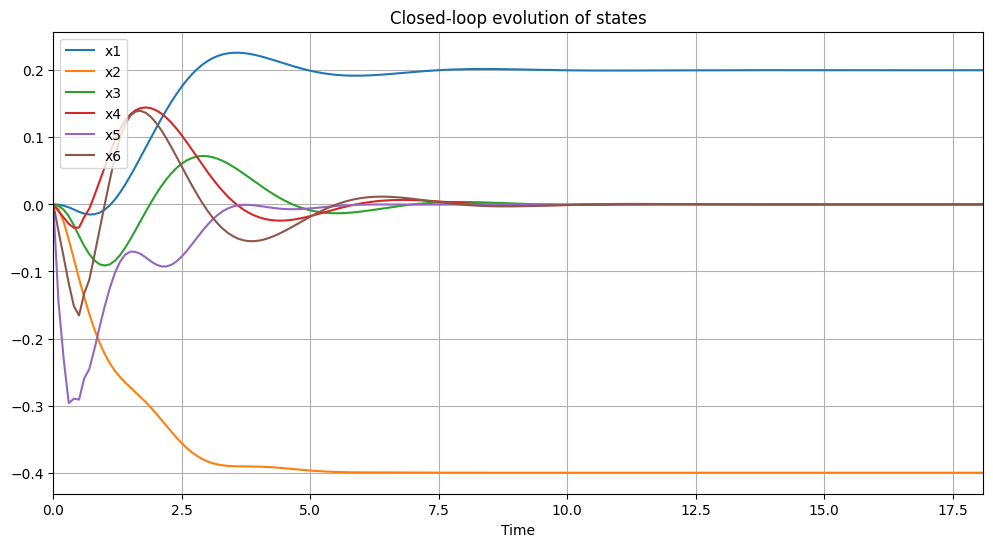

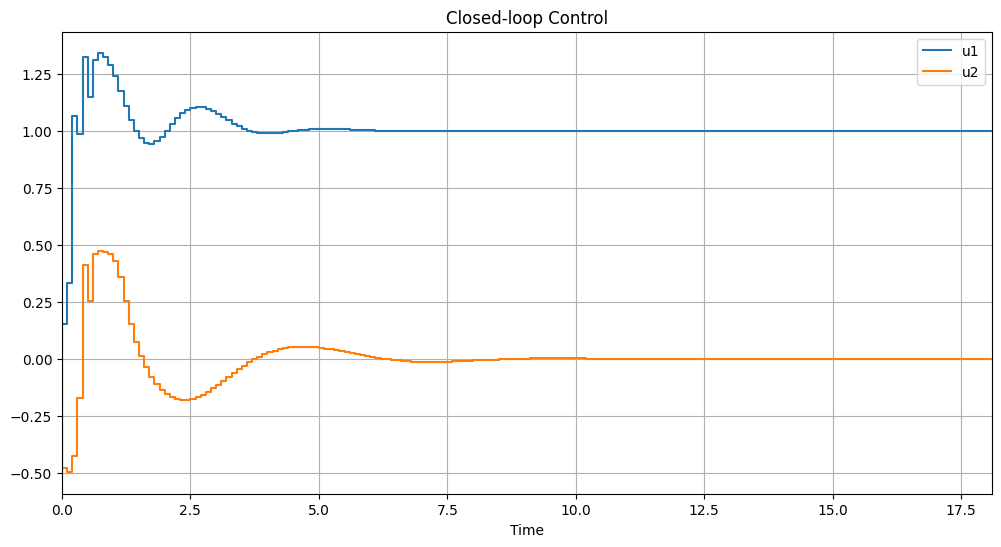

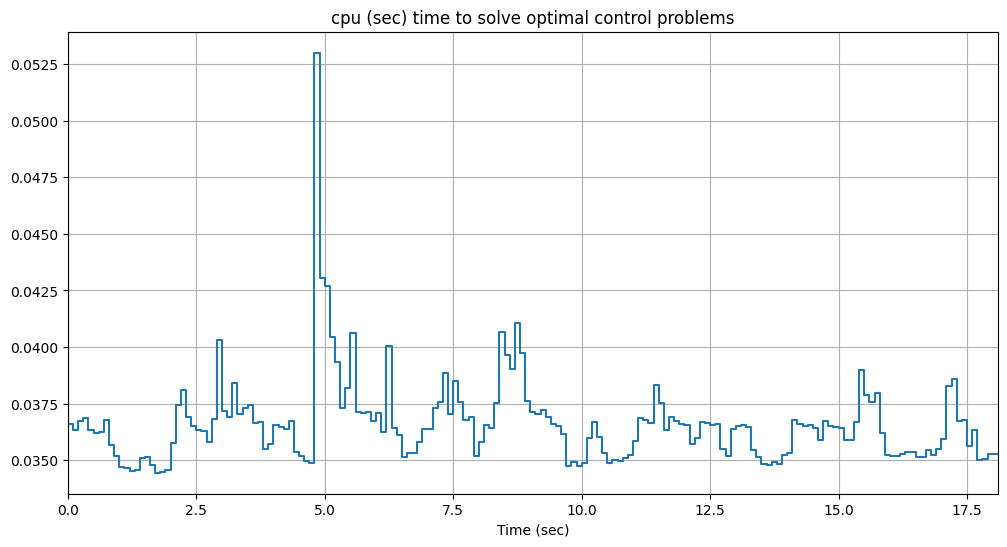

In [24]:
mpc.plot(R)

## Simulate the closed-loop using fast gradient

In [25]:
x0 = np.zeros(nx)
U0 = np.zeros(mpc.N * nu)
Nsim = 201
W_supposed = [0.4, 1] * Nsim
W_real = [0.25, 0.8] * Nsim
p = [0.2, -0.4, 100, 10, 10, 1e2]
rho_soft = 1e2
gam = 1e-5
c = 0.9
Niter = 50

R  = mpc.simulate_cl_fast_gradient(x0, U0, W_supposed, 
                                   W_real, p, rho_soft, Nsim, gam, c, Niter)

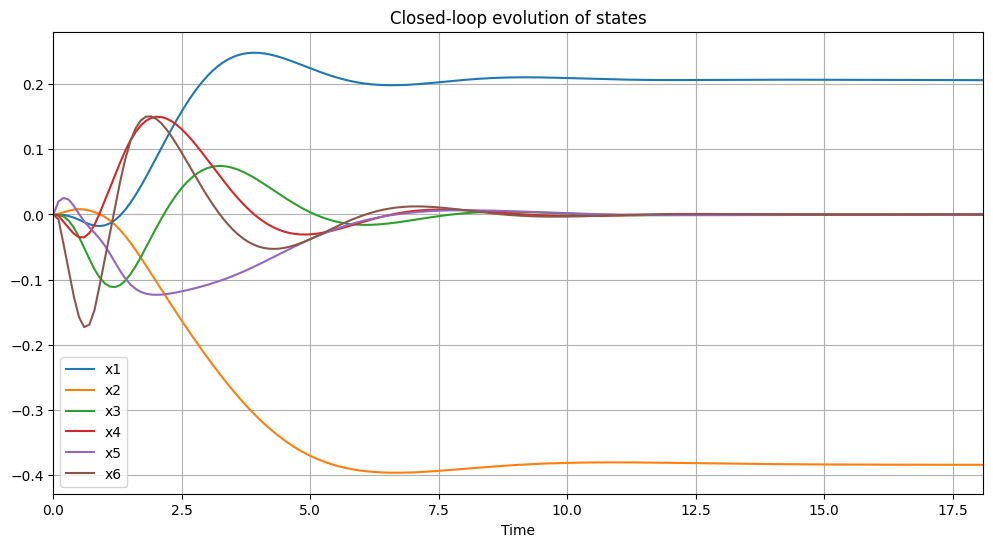

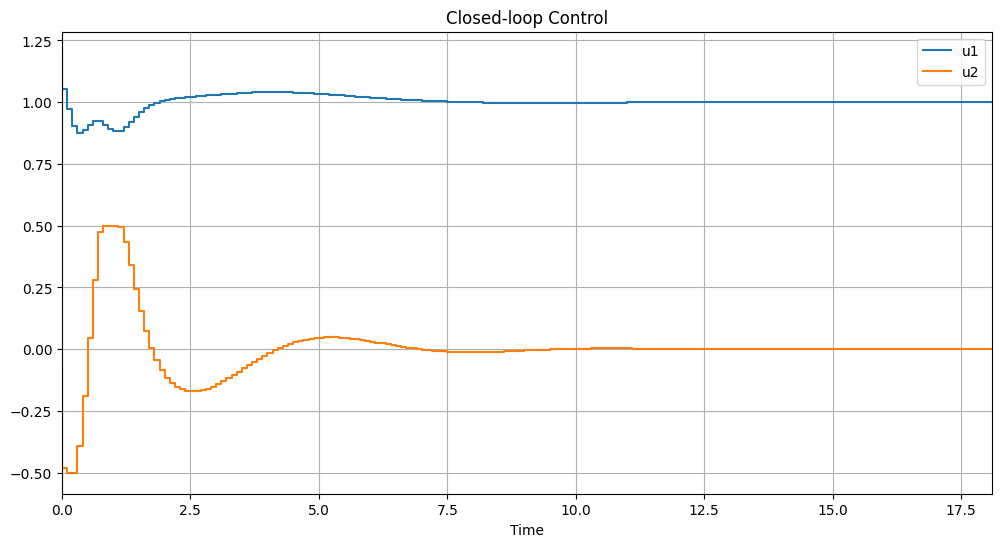

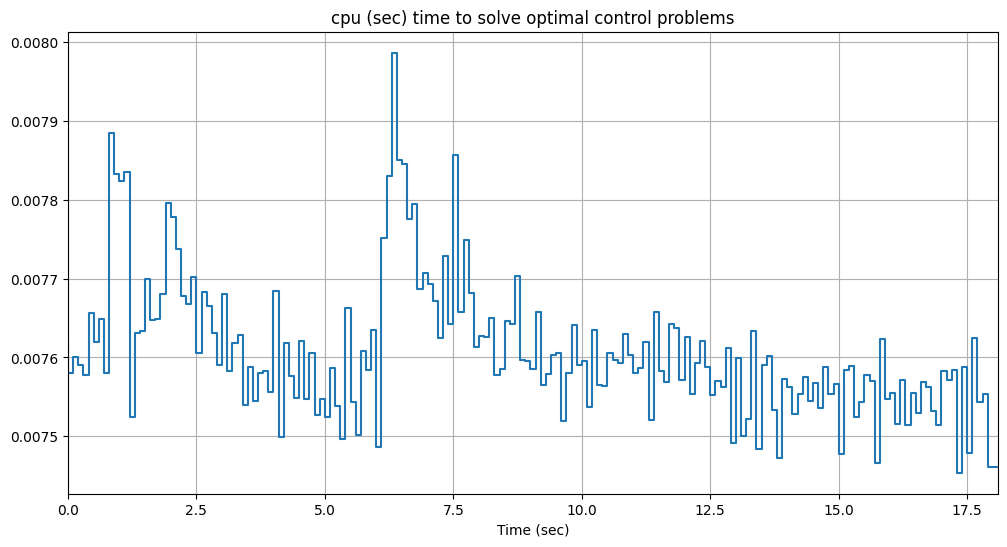

In [26]:
mpc.plot(R)

dict_keys(['RG_mismatch_50', 'RG_perfect_50', 'RG_mismatch_15', 'IPOPT_perfect_2000', 'IPOPT_Mismatch_2000', 'IPOPT_Mismatch_5'])


Text(0.5, 1.0, 'Cost function evolution under different conditions')

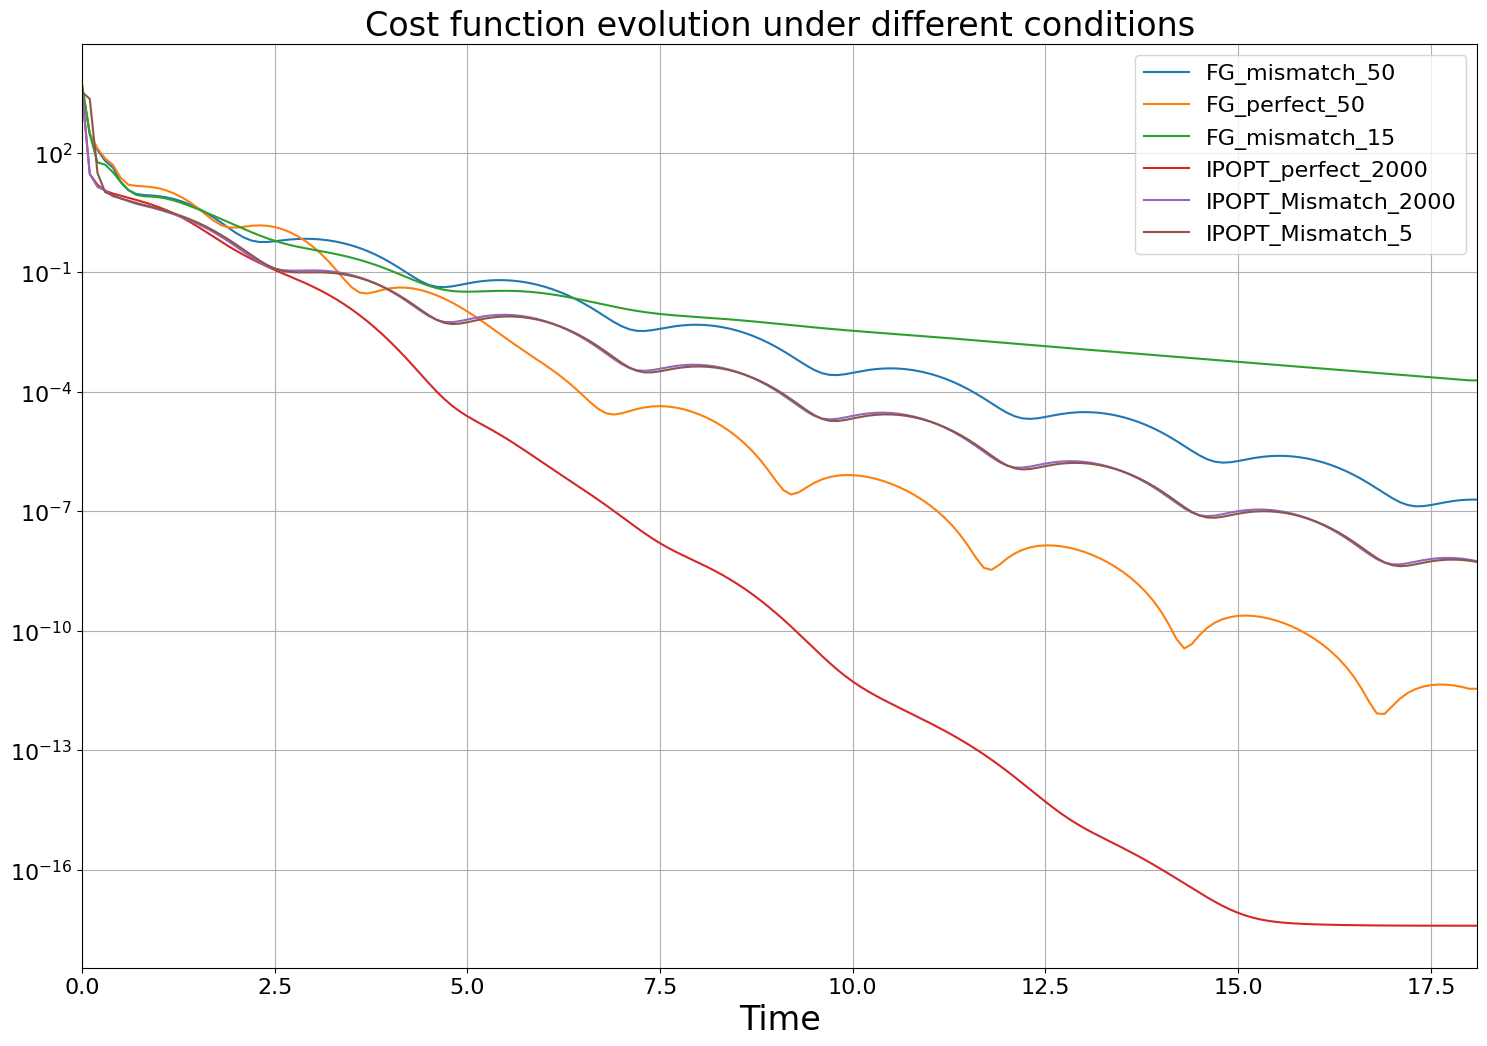

In [27]:
import pickle
import matplotlib.pyplot as plt 

lesR = pickle.load(open('lesR.pkl', 'rb'))
plt.figure(figsize=(18,12))
for key in lesR.keys():
    R = lesR[key]
    plt.semilogy(R.tcl, R.Jcl)
print(lesR.keys())
leg = ['FG_mismatch_50', 'FG_perfect_50', 'FG_mismatch_15', 'IPOPT_perfect_2000', 'IPOPT_Mismatch_2000', 'IPOPT_Mismatch_5']
plt.grid(True)
plt.xlim([R.tcl.min(), R.tcl.max()]);
plt.legend([key for key in leg], fontsize=16);
plt.xlabel('Time', fontsize=24);
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('Cost function evolution under different conditions', fontsize=24)

## Producing the comparison plots for the chapter dedicated to deterministic MPC solver

The above mentioned simualtions are repeated using different values of the parameters c, gam, Niter and max_iter and the results have been stored in four different dictionary: 

- lesR.pkl 
- lesRcGrad 
- lesRgamGrad 
- lesRgamGradN50



Text(0.5, 1.0, 'CPU-time under different conditions')

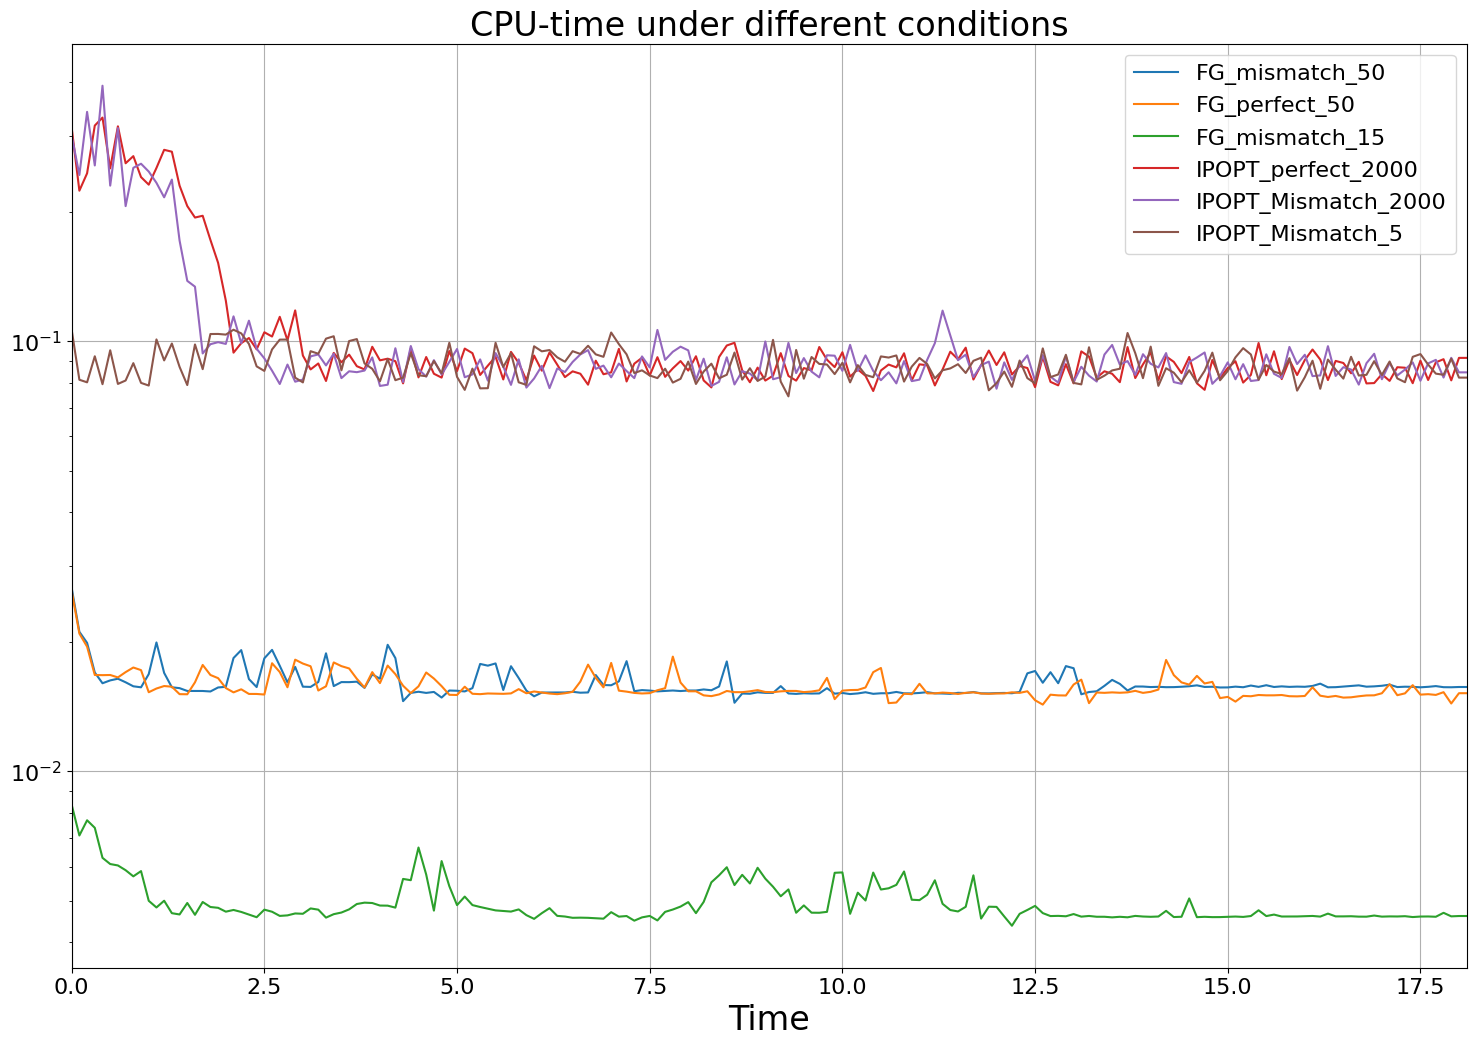

In [28]:
lesR = pickle.load(open('lesR.pkl', 'rb'))
plt.figure(figsize=(18,12))
for key in lesR.keys():
    R = lesR[key]
    plt.semilogy(R.tcl, R.cpu)

plt.grid(True)
plt.xlim([R.tcl.min(), R.tcl.max()]);
plt.legend([key for key in leg], fontsize=16);
plt.xlabel('Time', fontsize=24);
plt.tick_params(axis='both', which='major', labelsize=16)
plt.title('CPU-time under different conditions', fontsize=24)

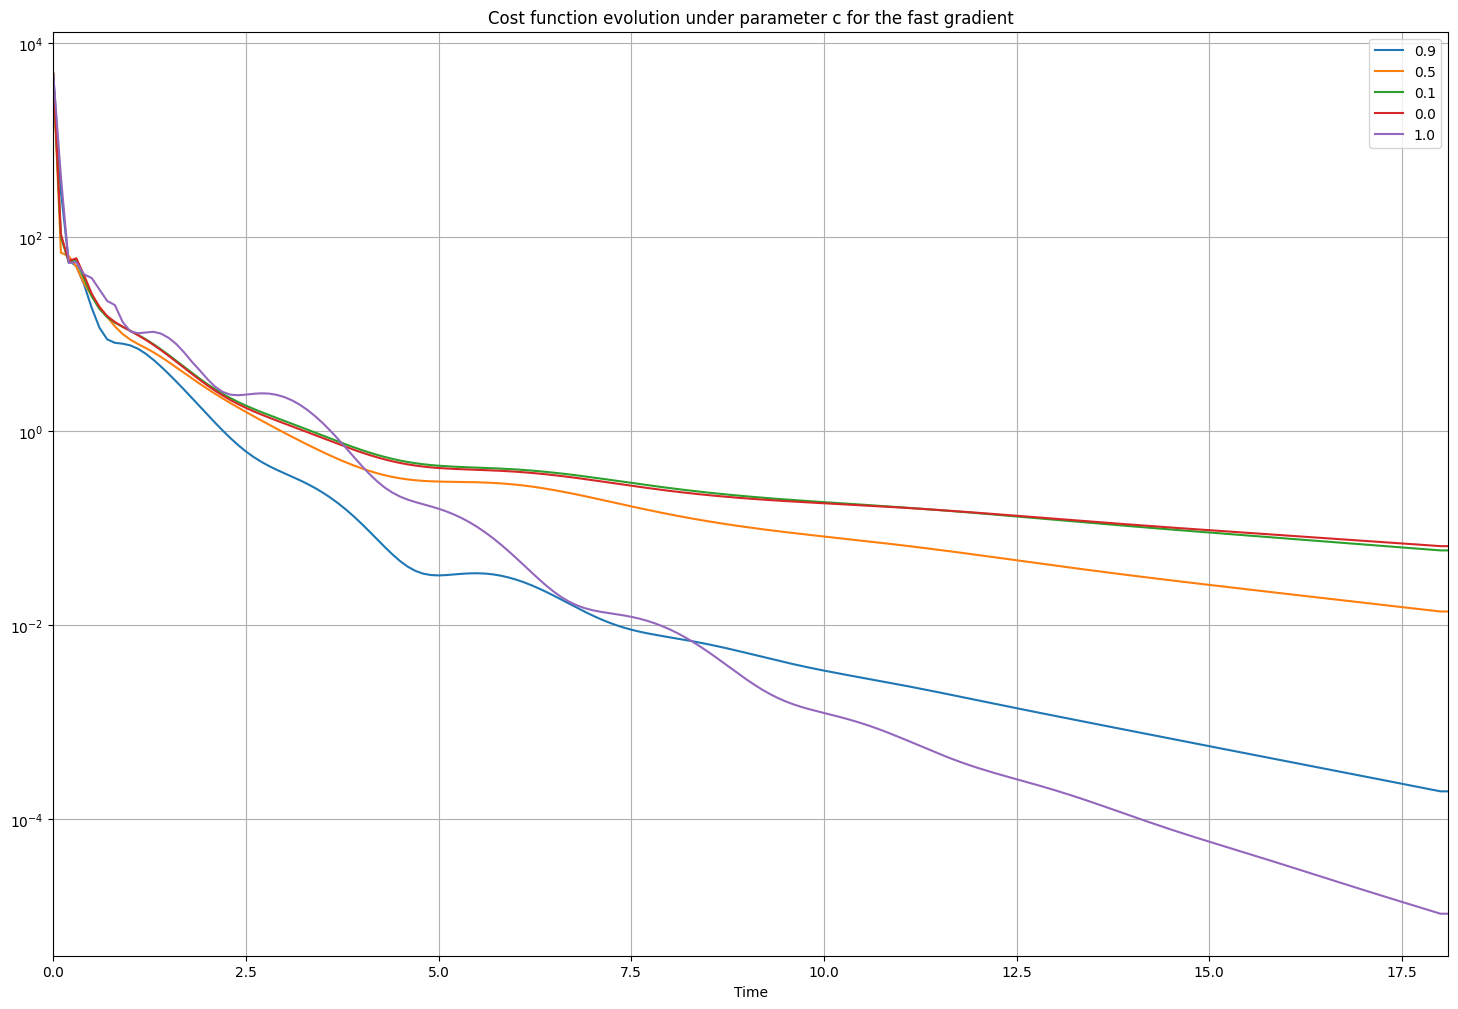

In [29]:
lesRcGrad = pickle.load(open('lesRcGrad.pkl', 'rb'))
plt.figure(figsize=(18,12))
for key in lesRcGrad.keys():
    R = lesRcGrad[key]
    plt.semilogy(R.tcl, R.Jcl)

plt.grid(True)
plt.xlim([R.tcl.min(), R.tcl.max()]);
plt.legend([key for key in lesRcGrad.keys()]);
plt.xlabel('Time');
plt.title('Cost function evolution under parameter c for the fast gradient');

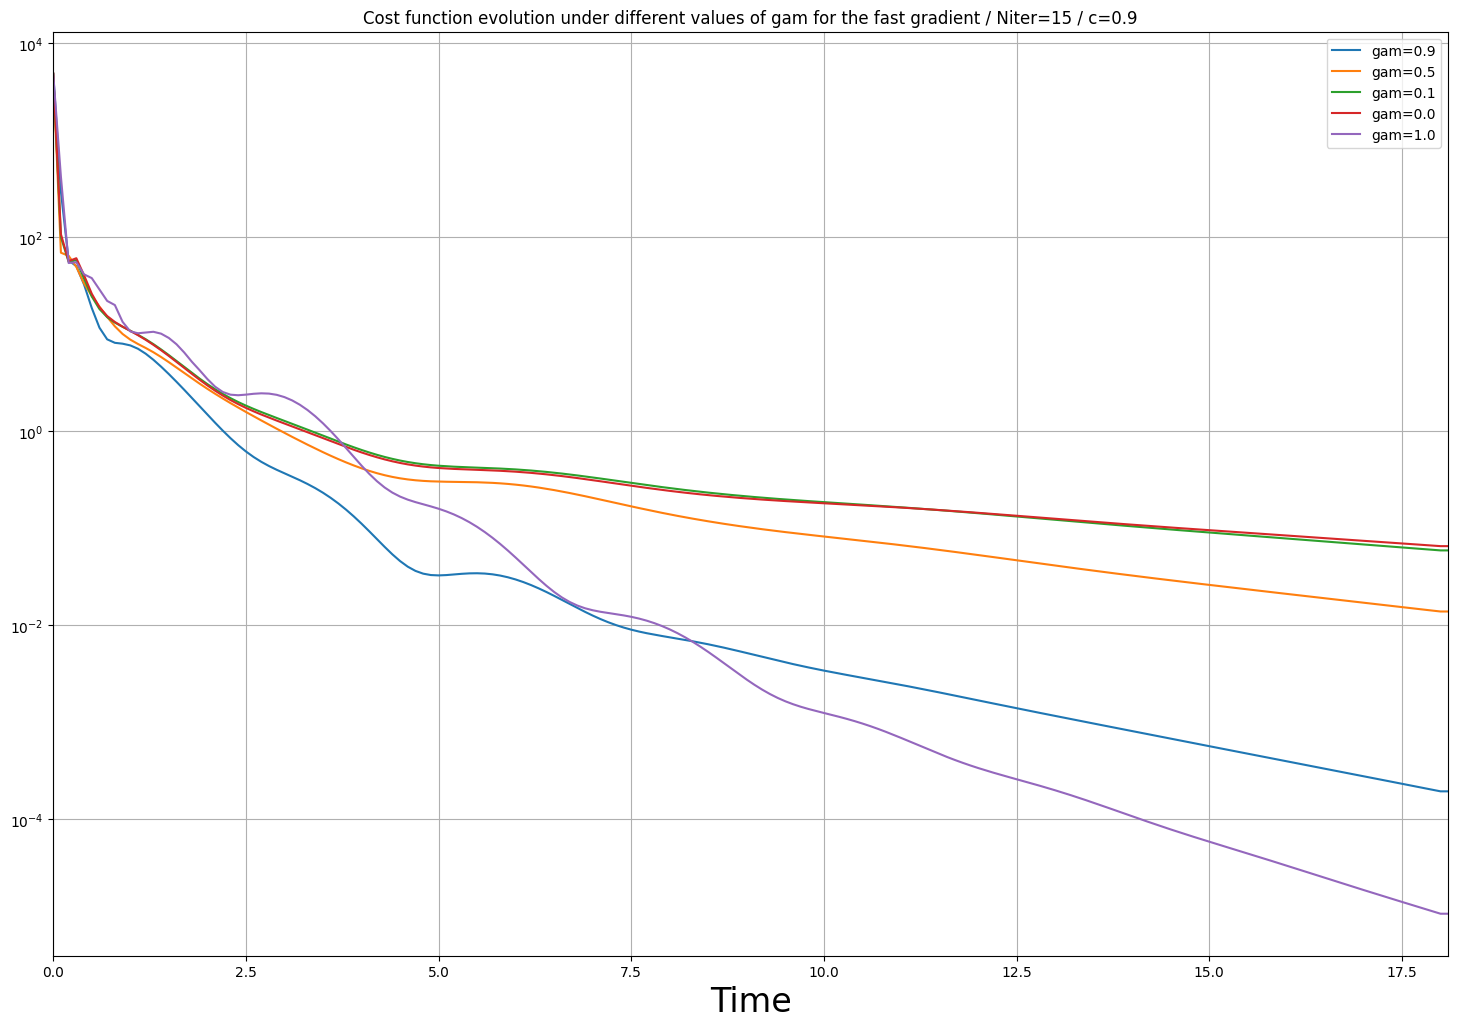

In [30]:
lesRgamGrad = pickle.load(open('lesRgamGrad.pkl', 'rb'))
plt.figure(figsize=(18,12))
for key in lesRgamGrad.keys():
    R = lesRgamGrad[key]
    plt.semilogy(R.tcl, R.Jcl)

plt.grid(True)
plt.xlim([R.tcl.min(), R.tcl.max()]);
plt.legend(['gam='+key for key in lesRgamGrad.keys()]);
plt.xlabel('Time', fontsize=24);
plt.title('Cost function evolution under different values of gam for the fast gradient / Niter=15 / c=0.9');

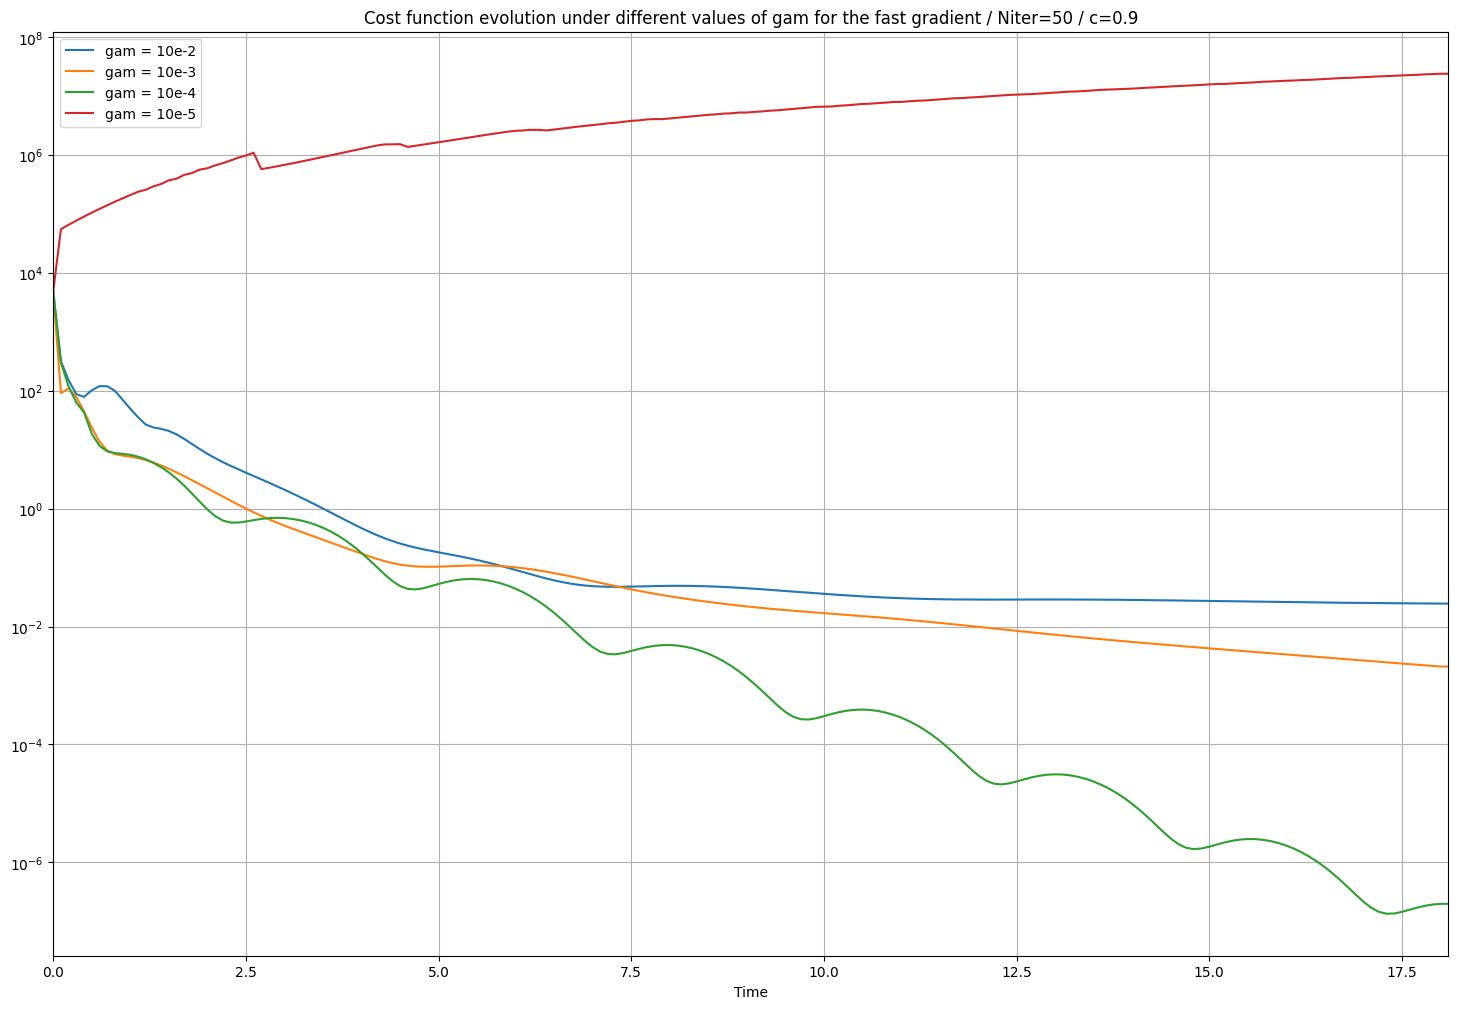

In [31]:
lesRgamGradN50 = pickle.load(open('lesRgamGradN50.pkl', 'rb'))
plt.figure(figsize=(18,12))
for key in ['10e-5', '10e-4', '10e-3', '10e-2']:
    R = lesRgamGradN50[key]
    plt.semilogy(R.tcl, R.Jcl)

plt.grid(True)
plt.xlim([R.tcl.min(), R.tcl.max()]);
plt.legend(['gam = '+key for key in lesRgamGradN50.keys()]);
plt.xlabel('Time');
plt.title('Cost function evolution under different values of gam for the fast gradient / Niter=50 / c=0.9');